At this stage, we have evaluated seven different indicators and strategies: Moving Average, Moving Average Crossovers, MACD, RSI, MFI, Bollinger Bands, and Fair Value Gaps (FVG). The overall conclusion from our tests has been somewhat disappointing—none of these indicators, when used individually, consistently outperformed the market.

However, we will now explore whether combining indicators yields better results.

We begin this new phase by testing a strategy that combines the MACD with the RSI.

In [27]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Note: We made a small adjustment to our get_data function to allow selecting the time interval for testing our strategies, while also ensuring the resulting plots are smooth and visually interpretable.

To build our combined strategy using MACD and RSI, we consider three main approaches:

1. Strict Confirmation (AND condition):
Only enter a buy (or sell) position when both the MACD and RSI signals agree. If the indicators provide conflicting signals, no trade is taken—effectively holding the current position. This is a more conservative and filtered approach.

2. Signal Aggregation (Weighted or Voting Logic):
Assign +1 to a bullish signal and -1 to a bearish signal from each indicator. Then sum both signals:

A combined value of +2 implies both indicators suggest a buy → enter long.

A combined value of -2 implies both suggest a sell → enter short.

Any other result (e.g., 0) means the indicators disagree → no position.

3. Hierarchical Filtering (Conditional Logic):
Establish a priority between the two indicators. For example, use MACD as the primary trend signal and only allow RSI signals to trigger trades when MACD confirms the trend direction. This is useful when one indicator is intended to act as a filter or context provider for the other.

In this case, we will be using option 2 to remain consistent with the logic we applied when building and testing each indicator individually.

Also we could define Risk to Reward ratios and test the win rate in our strategy, but for simplicity reasons (I'm still learning), we are going to stick with Signal Aggregation method that is defined above.

C:\Users\Ferna\AppData\Local\Temp\ipykernel_28624\4129243343.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD )
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,MACD_Strategy,RSI,RSI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
13,24.085651,24.380436,23.756186,24.380436,378100,24.505329,24.584474,0.079145,0.017640,0.061505,1.0,41.746728,NaN,NaN,0,NaN,NaN
14,24.172365,24.172365,24.050983,24.085664,34900,24.449552,24.540603,0.091051,0.032857,0.058194,1.0,44.444105,0.0,1.0,0,0.003600,0.000000
15,24.259071,24.293752,24.172370,24.241731,513600,24.418073,24.511646,0.093573,0.045352,0.048221,1.0,41.747599,0.0,1.0,0,0.007200,0.000000
16,24.241713,24.345754,24.120331,24.328414,373700,24.389257,24.484729,0.095472,0.055607,0.039865,1.0,39.603774,0.0,1.0,0,0.006479,0.000000
17,24.553848,24.553848,24.259063,24.259063,26300,24.415896,24.491432,0.075536,0.059666,0.015870,1.0,41.346490,0.0,1.0,0,0.019439,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8155,606.780029,607.849976,603.409973,604.330017,67735300,597.855195,590.646394,-7.208801,-7.941535,0.732735,1.0,62.793405,0.0,1.0,0,24.192594,2.850518
8156,607.119995,608.609985,605.539978,607.909973,62114800,599.280548,591.823080,-7.457469,-7.844722,0.387253,1.0,63.257648,0.0,1.0,0,24.206709,2.850518
8157,611.869995,612.309998,608.369995,608.989990,78548400,601.217386,593.255002,-7.962384,-7.868255,-0.094130,1.0,70.282021,0.0,1.0,0,24.403921,2.850518
8158,614.909973,616.390015,610.830017,612.880005,86258400,603.323938,594.801786,-8.522152,-7.999034,-0.523118,-1.0,68.391896,-1.0,-2.0,-1,24.530137,2.831387


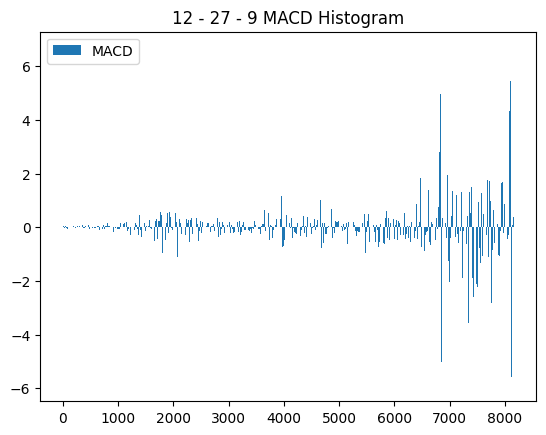

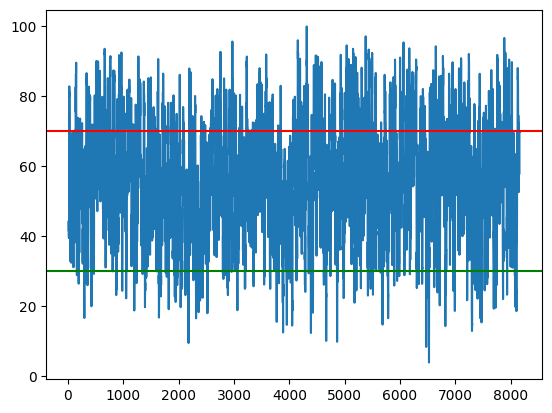

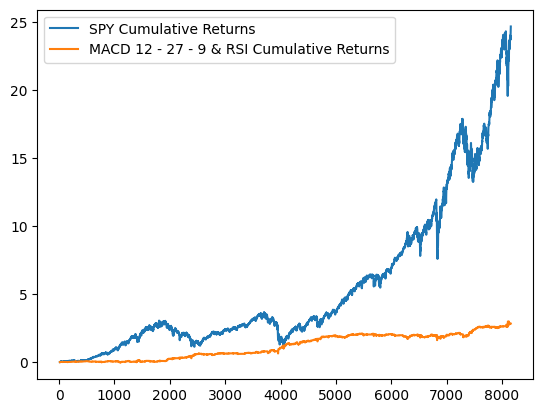

In [28]:
TICKER = 'SPY'
INTERVAL = '1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

# MACD parameters
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# RSI parameters
RSI_LENGHT = 14
OVERBOUGHT = 70 
OVERSOLD = 30

# subsection of data we are interested
LOOKBACK = 10000

def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # get data at interval
    df = yf.download(ticker, interval = interval, period = PERIOD ) 
    df.columns = df.columns.get_level_values(0)

    df = df.reset_index(drop = True) # Changes dates to numbers so we don't have weird weekend gaps when plotting

    return df.iloc[-lookback:,:] #Take a piece of the last "LOOKBACK" rows

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    df[f'{fast}_ema'] = df['Close'].ewm(span = fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span = slow).mean()

    df['MACD'] = df[f'{slow}_ema'] - df[f'{fast}_ema']

    df['Signal'] = df['MACD'].ewm(span = span).mean()

    #Part 2
    df['MACD_hist'] = df['MACD'] - df['Signal']

    #Plot
    plt.bar(x = df.index, height=df['MACD_hist']) 

    #for the bar graph make sure to define the indexes. The x index is a time index that is set by default on yfinance 
    plt.legend(['MACD', 'Signal'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):
    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)

    return df

def add_RSI(df, lenght = RSI_LENGHT):

    price_change = df['Close'].diff() #diff() => current value - previous value

    # Separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = - price_change.where(price_change < 0, 0)

    # Average gain vs loss
    avg_gain = gain.rolling(window = lenght).mean()
    avg_loss = loss.rolling(window = lenght).mean()

    # Calculate RSI
    rs = avg_gain/avg_loss # what % of the avg loss is the avg gain
    rsi = 100 - (100/(1 + rs))

    df['RSI'] = rsi

    # plot the RSI
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color = 'red')
    plt.axhline(OVERSOLD, color = 'green') 

    return df.dropna()

def add_RSI_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, np.where(df['RSI'] < oversold, 1, 0))
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)

    return df

def add_full_strategy(df):
    df['Full_Strategy'] = df['MACD_Strategy'] + df['RSI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])

    plt.legend([f'{TICKER} Cumulative Returns', f'MACD {MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} & RSI Cumulative Returns'])

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MACD_strategy(df)
    df = add_RSI(df)
    df = add_RSI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df

Now that we have programmatically built a strategy to test the combination of these two indicators, we can begin experimenting by adjusting their parameters or modifying the entry conditions for long and short positions. For example try to change np.where(df['MACD_hist'] > 0, 1, -1) to np.where(df['MACD_hist'] < 0, 1, -1) and see what happends.
This process may lead to more insightful and potentially more effective results.
Feel free to explore and tweak the code to run your own tests and discover what works best.